# KTP OCR Project
Oleh Teguh Rijanandi teguhrijanandi02@gmail.com

## Install Library yang dibutuhkan

In [1]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract
!pip install opencv-python
!pip install imutils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,920 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

## Download haarcascade_frontalface_default.xml

In [2]:
!wget https://raw.githubusercontent.com/teguh02/KTP-OCR-Python-Projects/main/haarcascade_frontalface_default.xml

--2024-03-06 14:32:44--  https://raw.githubusercontent.com/teguh02/KTP-OCR-Python-Projects/main/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254733 (1.2M) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>]   1.20M  --.-KB/s    in 0.06s   

2024-03-06 14:32:44 (21.7 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [1254733/1254733]



## Download contoh KTP

In [3]:
!wget https://raw.githubusercontent.com/teguh02/KTP-OCR-Python-Projects/main/ktp_contoh/ktp_contoh.jpg

--2024-03-06 14:32:44--  https://raw.githubusercontent.com/teguh02/KTP-OCR-Python-Projects/main/ktp_contoh/ktp_contoh.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131257 (128K) [image/jpeg]
Saving to: ‘ktp_contoh.jpg’

ktp_contoh.jpg      100%[===================>] 128.18K  --.-KB/s    in 0.02s   

2024-03-06 14:32:45 (5.61 MB/s) - ‘ktp_contoh.jpg’ saved [131257/131257]



# Definisi Fungsi dan Library

## Import library python

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pytesseract
import json
import imutils
import sys

## Cek versi library

In [5]:
print("Versi Python:", sys.version)
print("Versi pytesseract:", pytesseract.__version__)
print("Versi OpenCV:", cv2.__version__)
print("Versi imutils:", imutils.__version__)
print("Versi matplotlib:", matplotlib.__version__)

Versi Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Versi pytesseract: 0.3.10
Versi OpenCV: 4.8.0
Versi imutils: 0.5.4
Versi matplotlib: 3.7.1


## Fungsi untuk memeriksa kualitas gambar



In [6]:
def check_image_quality(image_path):
    # 1. Cek apakah file tidak kosong
    if not image_path:
        return {
            'status': False,
            'error': "File tidak boleh kosong."
        }

    # 2. Cek apakah file merupakan file gambar
    try:
        image = cv2.imread(image_path)
        if image is None:
            return {
                'status': False,
                'error': "File bukan gambar atau tidak dapat dibaca."
            }
    except Exception as e:
        return {
            'status': False,
            'error': "Terjadi kesalahan saat membaca file: {}".format(str(e))
        }

    # 3. Cek resolusi gambar
    height, width, _ = image.shape
    min_resolution = (800, 600)  # Atur sesuai dengan kebutuhan
    if height < min_resolution[1] or width < min_resolution[0]:
        return {
            'status': False,
            'error': "Resolusi gambar terlalu kecil. Harap gunakan gambar dengan resolusi minimal {}x{}.".format(min_resolution[0], min_resolution[1])
        }

    # 4. Cek tingkat keburaman gambar
    blur_threshold = 100  # Atur sesuai dengan kebutuhan
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_score = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    if blur_score < blur_threshold:
        return {
            'status': False,
            'error': "Gambar terlalu buram. Harap gunakan gambar yang lebih jelas."
        }

    # Jika semua pengecekan berhasil, kembalikan status True tanpa error
    return {
        'status': True,
        'error': None
    }

## Fungsi untuk pendeteksian wajah pada KTP

In [7]:
def detect_and_outline(image):
    # Implementasi deteksi dan penjajaran
    # Misalnya, menggunakan algoritma deteksi wajah Haar cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

    # Gambar kotak persegi panjang di sekitar setiap wajah
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Kembalikan gambar hasil deteksi dan objek yang telah di-outline
    return image, faces

## Fungsi untuk menghilangkan gambar wajah menjadi hitam

In [8]:
def remove_faces(image, faces):
    # Cek apakah image adalah numpy array
    if isinstance(image, np.ndarray):
        # Jika ya, buat salinan gambar asli
        image_copy = np.copy(image)
    else:
        # Jika tidak, gunakan image copy
        image_copy = image.copy()

    # Ganti area wajah dengan warna hitam
    for (x, y, w, h) in faces:
        image_copy[y:y+h, x:x+w] = (0, 0, 0)  # (0, 0, 0) merupakan warna hitam dalam ruang warna BGR

    return image_copy

## Fungsi untuk ekstraksi teks

In [9]:
def text_detection(image):
    # Cek apakah image adalah numpy array
    if isinstance(image, np.ndarray):
        # Jika ya, buat salinan gambar asli
        image_copy = np.copy(image)
    else:
        # Jika tidak, gunakan image copy
        image_copy = image.copy()

    # Lakukan deteksi teks dengan Tesseract OCR
    detected_text_result = pytesseract.image_to_string(image_copy)
    # Bagi teks menjadi baris-baris
    detected_text_lines = detected_text_result.split('\n')
    # Hapus baris kosong
    detected_text_lines = [line.strip() for line in detected_text_lines if line.strip()]
    return detected_text_lines

## Parsing key dan value

In [10]:
def separate_key_value(text_list):
    extracted_information = {}
    for line in text_list:
        # Pisahkan baris teks menjadi key dan value menggunakan tanda ":"
        parts = line.split(':')
        if len(parts) >= 2:
            key = parts[0].strip()
            value = ':'.join(parts[1:]).strip()
            extracted_information[key] = value
    return extracted_information

## Bersihkan special character

In [11]:
def clean_json_values(json_data):
    def clean_special_characters(text):
        # Tentukan tanda-tanda asing yang ingin dihapus
        special_characters = {'`', '~', '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+', '=', '{', '}', '[', ']', '|', '\\', ';', '"', "'", '<', '>', ',', '.', '?', '\u2014', '\u20262'}

        # Hapus tanda-tanda asing yang ditentukan dari teks
        cleaned_text = ''.join(c for c in text if c not in special_characters)
        return cleaned_text

    # Membersihkan tanda-tanda asing dari setiap kunci dan nilai dalam data JSON
    cleaned_json_data = {}
    for key, value in json_data.items():
        # Membersihkan tanda-tanda asing dari kunci
        cleaned_key = clean_special_characters(key)
        # cleaned_key = key
        # Menghapus spasi dari kunci
        # cleaned_key = cleaned_key.replace(' ', '_')
        # Membersihkan tanda-tanda asing dari nilai
        cleaned_value = clean_special_characters(value)
        cleaned_json_data[cleaned_key] = cleaned_value
    return cleaned_json_data

# Proses Ekstraksi

## Definisi ekstraksi

In [12]:
filepath = 'ktp_contoh.jpg'
check_image = check_image_quality(filepath)

if check_image['status'] == True:
  image = cv2.imread(filepath)
else:
  print(check_image['error'])

## Deteksi wajah

In [13]:
detected, outlined = detect_and_outline(image)

## Hilangkan wajah

In [14]:
remove_faces = remove_faces(detected, outlined)

## Pendeteksian Teks

In [15]:
text_detection = text_detection(remove_faces)
print(json.dumps(text_detection, indent=2))

[
  "PROVINSI DKI JAKARTA",
  "JAKARTA TIMUR",
  "NIK : 3175070101909999",
  "Nama : BILLY BUMBLEBEE SIFULAN",
  "Tempat/Tgl Lahir : SURABAYA, 01-01-1990",
  "Jenis Kelamin : LAKI-LAKI Gol. Darah : AB",
  "Alamat : JL DIMANA NO 100",
  "RT/RW : 001/001",
  "Kel/Desa : ANTAH BERANTAH",
  "Kecamatan : DUREN SAWIT",
  "Agama : ISLAM",
  "Status Perkawinan: KAWIN",
  "Pekerjaan : KARYAWAN SWASTA.",
  "Kewarganegaraan : WNI pORARTE TIMOR",
  "01-01-2020",
  "Berlaku Hingga :SEUMUR HIDUP"
]


## Pisahkan key dan value

In [16]:
separate_key_value = separate_key_value(text_detection)
print(json.dumps(separate_key_value, indent=2))

{
  "NIK": "3175070101909999",
  "Nama": "BILLY BUMBLEBEE SIFULAN",
  "Tempat/Tgl Lahir": "SURABAYA, 01-01-1990",
  "Jenis Kelamin": "LAKI-LAKI Gol. Darah : AB",
  "Alamat": "JL DIMANA NO 100",
  "RT/RW": "001/001",
  "Kel/Desa": "ANTAH BERANTAH",
  "Kecamatan": "DUREN SAWIT",
  "Agama": "ISLAM",
  "Status Perkawinan": "KAWIN",
  "Pekerjaan": "KARYAWAN SWASTA.",
  "Kewarganegaraan": "WNI pORARTE TIMOR",
  "Berlaku Hingga": "SEUMUR HIDUP"
}


## Bersihkan karakter spesial

In [17]:
clean_json_values = clean_json_values(separate_key_value)
print(json.dumps(clean_json_values, indent=2))

{
  "NIK": "3175070101909999",
  "Nama": "BILLY BUMBLEBEE SIFULAN",
  "Tempat/Tgl Lahir": "SURABAYA 01-01-1990",
  "Jenis Kelamin": "LAKI-LAKI Gol Darah : AB",
  "Alamat": "JL DIMANA NO 100",
  "RT/RW": "001/001",
  "Kel/Desa": "ANTAH BERANTAH",
  "Kecamatan": "DUREN SAWIT",
  "Agama": "ISLAM",
  "Status Perkawinan": "KAWIN",
  "Pekerjaan": "KARYAWAN SWASTA",
  "Kewarganegaraan": "WNI pORARTE TIMOR",
  "Berlaku Hingga": "SEUMUR HIDUP"
}


## Tampilkan hasil KTP

### Hasil Deteksi Wajah

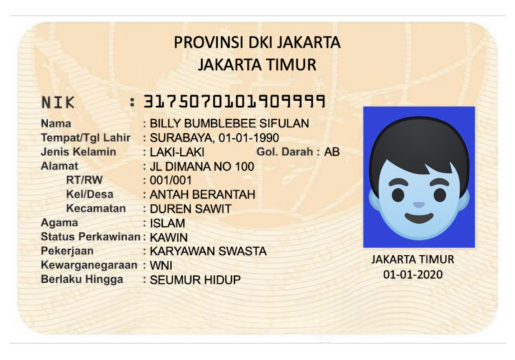

In [18]:
plt.imshow(detected)
plt.axis('off')
plt.show()

### Contoh hasil deteksi yang sudah dilakukan sebelumnya dan sudah di sensor

In [19]:
!pip install requests

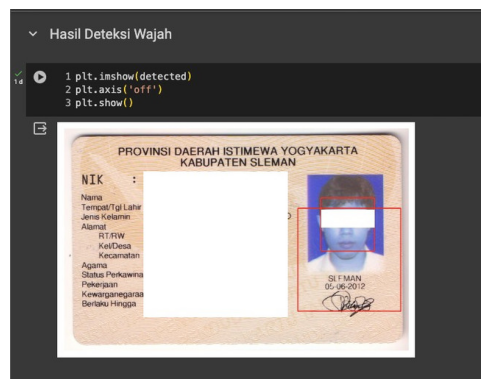

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from io import BytesIO

# URL gambar
url = "https://i.ibb.co/j594SVS/Hasil-Deteksi-Wajah-Sensored.jpg"

# Unduh gambar dari URL
response = requests.get(url)
img = mpimg.imread(BytesIO(response.content), format='jpeg')

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')  # Menghilangkan sumbu
plt.show()


### Hasil penghapusan wajah menjadi hitam (Hasil Akhir Gambar KTP)
Note :
Wajah tidak akan terhapus jika wajah dari KTP tersebut merupakan gambar animasi, wajah tersebut harus asli manusia. Mengapa demikian? karena dataset haarcascade_frontalface_default.xml yang digunakan merupakan dataset asli wajah manusia

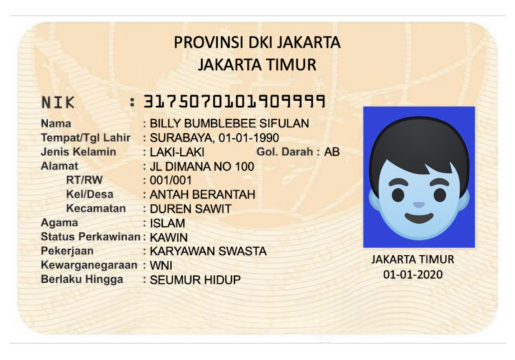

In [21]:
plt.imshow(remove_faces)
plt.axis('off')
plt.show()